In [1]:
import pickle
import pandas as pd
pd.options.display.max_columns = None
import matplotlib.pyplot as plt

In [85]:
with open('data/compiled_data_sources/df_res.pkl', 'rb') as f:
    blast = pickle.load(f)
    
blast['expect'] = pd.to_numeric(blast['expect'])
blast['score'] = pd.to_numeric(blast['score'])
blast = blast.sort_values(by=['expect', 'score'])
blast = blast.drop_duplicates(subset=['query'], keep='first') #get rid of same query appraring multiple times
blast.to_csv('data/compiled_data_sources/blast_few.csv', index=None)

# Add biotypes
biot = pd.read_csv('data/compiled_data_sources/ncRNA_g200_biotypes.csv')
biot['ncRNA_id'] = [e.split('.')[0] for e in biot['ncRNA_id']]
biot = biot.drop(['ncRNA_biotype_gene'], axis=1)
blast = blast.merge(biot, left_on='query', right_on='ncRNA_id').drop(['ncRNA_id'], axis=1)

# Add sequences
with open('data/compiled_data_sources/misannot_lncRNAs.fa', 'r') as f:
    contents = f.readlines()
    contents = [l.strip() for l in contents]
    ids = [id.replace('>', '') for id in contents[0::2]]
    seqs = contents[1::2]
seq = pd.DataFrame({'query': ids, 'RNA': seqs})
blast = blast.merge(seq, on='query')

# Add train dyn
cnn = pd.read_csv('data/model_predictions/cnn_29_test_predict_hist.csv').drop(['Unnamed: 0'], axis=1)
cnn['id'] = [e.split('.')[0] for e in cnn['id']]
cnn.columns = ['id', 'gold_lab', 'mean_cnn', 'std_cnn']
blast = blast.merge(cnn, left_on='query', right_on='id').drop(['id','gold_lab'], axis=1)


lstm = pd.read_csv('data/model_predictions/lstm_29_test_predict_hist.csv').drop(['Unnamed: 0'], axis=1)
lstm['id'] = [e.split('.')[0] for e in lstm['id']]
lstm.columns = ['id', 'gold_lab', 'mean_lstm', 'std_lstm']
blast = blast.merge(lstm, left_on='query', right_on='id').drop(['id','gold_lab'], axis=1)

transf = pd.read_csv('data/model_predictions/transformer_29_test_hist.csv').drop(['Unnamed: 0'], axis=1)
transf['id'] = [e.split('.')[0] for e in transf['id']]
transf.columns = ['id', 'gold_lab', 'mean_transf', 'std_transf']
blast = blast.merge(transf, left_on='query', right_on='id').drop(['id','gold_lab'], axis=1)

blast = blast.sort_values(by=['mean_lstm','mean_cnn','mean_transf',
                              'std_lstm','std_cnn','std_transf'])

# Ribo-seq data
ribo = pd.read_csv('data/compiled_data_sources/ribo_seq.txt', sep='\t')
ribo = ribo[(ribo['Annotation'] == 'lncrna')]
ribo = ribo[['Cell line', 'Chromosome', 'Sorf length', 'Start codon',
       'Annotation', 'Biotype', 'Floss-Classification', 'FLOSS score',
       'Orfscore', 'PhyloP', 'cutoff p-value', 'PhastCon',
       'Ensembl transcript ID','PeptideShaker confidence']]
ribo = ribo.sort_values(by=['cutoff p-value']) #sort by pval
ribo = ribo.drop_duplicates(subset=['Ensembl transcript ID'], keep='first') #get rid of same query appraring multiple times
blast_ribo_left = blast.merge(ribo, how='left', left_on='query', right_on='Ensembl transcript ID') #try outer?
blast_ribo_inner = blast.merge(ribo, how='inner', left_on='query', right_on='Ensembl transcript ID') 

blast_ribo_left.to_csv('data/compiled_data_sources/blast_dyn_ribo_merged_candidates.csv')
blast_ribo_left

/opt/homebrew/Caskroom/miniconda/base/envs/at/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (2,13) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,query,length,sequence,score,expect,method,identities,positives,gaps,frame,ncRNA_biotype,RNA,mean_cnn,std_cnn,mean_lstm,std_lstm,mean_transf,std_transf,Cell line,Chromosome,Sorf length,Start codon,Annotation,Biotype,Floss-Classification,FLOSS score,Orfscore,PhyloP,cutoff p-value,PhastCon,Ensembl transcript ID,PeptideShaker confidence
0,ENST00000621052,1275,O00370,140.0,4.000000e-32,Compositional matrix adjust.,66/84 (79%),73/84 (87%),0/84 (0%),-2,lincRNA,CCACCTCTGCAGGGGTGCGTCTGGAGGAGGTGGACCAGCCACCAAC...,0.002875,0.002096,0.002429,0.002959,0.005825,0.001522,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ENST00000549804,1032,B0Y4D6,37.0,3.200000e+00,Compositional matrix adjust.,26/73 (36%),39/73 (53%),4/73 (5%),-3,antisense_RNA,ACCTTGTTCTTGAGCTGTCCGGTTGCCACAGGGTCGGACCTGGAGG...,0.015498,0.005277,0.005391,0.007809,0.061600,0.008495,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,ENST00000415801,159,Q96CB5,64.3,2.000000e-10,Compositional matrix adjust.,31/44 (70%),36/44 (82%),0/44 (0%),-1,lincRNA,TATCAACTCCATCTGTCACAAAAATTAAGGCTAAATCTCCTCTCCA...,0.004626,0.001986,0.005642,0.006027,0.022841,0.004528,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ENST00000609590,367,O54689,557.0,0.000000e+00,Compositional matrix adjust.,276/370 (75%),320/370 (86%),4/370 (1%),+3,retained_intron,GAAGCAAGATGGCGGCGACGGCGGCCGCAGTGGTGGCCGAGGAGGA...,0.006486,0.002971,0.005936,0.005219,0.005044,0.002597,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ENST00000523176,683,O94929,69.3,2.000000e-10,Compositional matrix adjust.,30/30 (100%),30/30 (100%),0/30 (0%),-2,antisense_RNA,ACACAAAGCTGTCTAATTCAGTATTTAAAACAGAGCAGGGACTCAA...,0.003889,0.001884,0.006060,0.003457,0.050220,0.027557,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1318,ENST00000588290,531,Q9NV72,38.9,1.200000e-02,Composition-based stats.,19/30 (63%),20/30 (67%),0/30 (0%),-1,antisense_RNA,TGTGGCTCACGTCTGTACTCCCAGAGCCTTGGGAGGTCGAGGCGGG...,0.894865,0.136203,0.931992,0.055017,0.437800,0.041088,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1319,ENST00000521197,401,Q5IS58,35.8,2.700000e-01,Compositional matrix adjust.,22/61 (36%),33/61 (54%),2/61 (3%),-1,antisense_RNA,AAAACCCTATTCATTTGGCACCCAAATGTCATATAGCCGGAACTGG...,0.877579,0.201907,0.934013,0.087340,0.485180,0.017788,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1320,ENST00000641534,464,P04198,71.2,3.000000e-14,Compositional matrix adjust.,32/32 (100%),32/32 (100%),0/32 (0%),-1,antisense_RNA,GACAGCGGGGGCGTGGGCAGCAGCTCAAACTTCTTCCAGATGTCCT...,0.841271,0.292935,0.942631,0.061774,0.474056,0.082061,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1321,ENST00000528233,230,Q96NF6,66.6,3.000000e-12,Compositional matrix adjust.,35/55 (64%),37/55 (67%),2/55 (4%),+3,sense_intronic,TTTTCATTCCCTAAGAATAAATGTGTACTGATTAATCTCATGGGAG...,0.897007,0.202062,0.945937,0.075987,0.484572,0.045860,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [60]:
# write seqs from dyn into fa so we can run other cpp tools
ids = blast_ribo_left['query'].dropna().tolist()
seqs = blast_ribo_left['RNA'].dropna().tolist()

fName = 'data/compiled_data_sources/coding_potential_pred_tools/cpp_tools_input_misannots_dyn_blast.fa'
fo = open(fName, "w")
for i in range(len(ids)):
    fo.write('>' + str(ids[i]) + '\n'+ str(seqs[i]) + '\n')
fo.close()

# Merge results from cpp tools

In [132]:
samba = pd.read_csv('data/compiled_data_sources/coding_potential_pred_tools/rnasamba.tsv', sep='\t')
samba.columns = ['query', 'rnasamba_coding_score', 'rnasamba_classification']

cpat = pd.read_csv('data/compiled_data_sources/coding_potential_pred_tools/cpat.txt', sep='\t')
cpat.columns = ['Data ID', 'query', 'cpat_RNA_len', 'cpat_ORF_len', 'cpat_Ficket_Score',
       'cpat_Hexamer_Score', 'cpat_Coding_Probability', 'cpat_Coding_Label']
cpat = cpat.drop(['Data ID'], axis=1)

cpc2 = pd.read_csv('data/compiled_data_sources/coding_potential_pred_tools/cpc2.txt', sep='\t')
cpc2.columns = ['query', 'cpc2_peptide_length', 'cpc2_Fickett_score', 'cpc2_pI', 'cpc2_ORF_integrity',
       'cpc2_coding_probability', 'cpc2_label']

cpp = samba.merge(cpat, on='query')
cpp = cpp.merge(cpc2, on='query')


# merge w blast
final = blast_ribo_left.merge(cpp, on='query')
final

,query,length,sequence,score,expect,method,identities,positives,gaps,frame,ncRNA_biotype,RNA,mean_cnn,std_cnn,mean_lstm,std_lstm,mean_transf,std_transf,Cell line,Chromosome,Sorf length,Start codon,Annotation,Biotype,Floss-Classification,FLOSS score,Orfscore,PhyloP,cutoff p-value,PhastCon,Ensembl transcript ID,PeptideShaker confidence,rnasamba_coding_score,rnasamba_classification,cpat_RNA_len,cpat_ORF_len,cpat_Ficket_Score,cpat_Hexamer_Score,cpat_Coding_Probability,cpat_Coding_Label,cpc2_peptide_length,cpc2_Fickett_score,cpc2_pI,cpc2_ORF_integrity,cpc2_coding_probability,cpc2_label
0,ENST00000621052,1275,O00370,140.0,4.000000e-32,Compositional matrix adjust.,66/84 (79%),73/84 (87%),0/84 (0%),-2,lincRNA,CCACCTCTGCAGGGGTGCGTCTGGAGGAGGTGGACCAGCCACCAAC...,0.002875,0.002096,0.002429,0.002959,0.005825,0.001522,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.40144,noncoding,4222,357,0.7614,0.084580,0.176134,no,119,0.32138,9.771179,1,0.207399,noncoding
1,ENST00000549804,1032,B0Y4D6,37.0,3.200000e+00,Compositional matrix adjust.,26/73 (36%),39/73 (53%),4/73 (5%),-3,antisense_RNA,ACCTTGTTCTTGAGCTGTCCGGTTGCCACAGGGTCGGACCTGGAGG...,0.015498,0.005277,0.005391,0.007809,0.061600,0.008495,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.29709,noncoding,7844,471,0.5745,0.044105,0.200269,no,157,0.29751,10.697449,1,0.312078,noncoding
2,ENST00000415801,159,Q96CB5,64.3,2.000000e-10,Compositional matrix adjust.,31/44 (70%),36/44 (82%),0/44 (0%),-1,lincRNA,TATCAACTCCATCTGTCACAAAAATTAAGGCTAAATCTCCTCTCCA...,0.004626,0.001986,0.005642,0.006027,0.022841,0.004528,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.09200,noncoding,4387,219,0.5042,-0.389595,0.000926,no,73,0.27517,8.802551,1,0.037926,noncoding
3,ENST00000609590,367,O54689,557.0,0.000000e+00,Compositional matrix adjust.,276/370 (75%),320/370 (86%),4/370 (1%),+3,retained_intron,GAAGCAAGATGGCGGCGACGGCGGCCGCAGTGGTGGCCGAGGAGGA...,0.006486,0.002971,0.005936,0.005219,0.005044,0.002597,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.99657,coding,5310,1125,1.1033,0.178319,0.999772,yes,375,0.39772,9.226746,1,0.999998,coding
4,ENST00000523176,683,O94929,69.3,2.000000e-10,Compositional matrix adjust.,30/30 (100%),30/30 (100%),0/30 (0%),-2,antisense_RNA,ACACAAAGCTGTCTAATTCAGTATTTAAAACAGAGCAGGGACTCAA...,0.003889,0.001884,0.006060,0.003457,0.050220,0.027557,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.01239,noncoding,4533,270,0.6999,-0.059721,0.025377,no,90,0.27587,9.950134,1,0.064906,noncoding
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1318,ENST00000588290,531,Q9NV72,38.9,1.200000e-02,Composition-based stats.,19/30 (63%),20/30 (67%),0/30 (0%),-1,antisense_RNA,TGTGGCTCACGTCTGTACTCCCAGAGCCTTGGGAGGTCGAGGCGGG...,0.894865,0.136203,0.931992,0.055017,0.437800,0.041088,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.13153,noncoding,469,132,0.8317,-0.152579,0.006105,no,44,0.44540,12.302185,1,0.049049,noncoding
1319,ENST00000521197,401,Q5IS58,35.8,2.700000e-01,Compositional matrix adjust.,22/61 (36%),33/61 (54%),2/61 (3%),-1,antisense_RNA,AAAACCCTATTCATTTGGCACCCAAATGTCATATAGCCGGAACTGG...,0.877579,0.201907,0.934013,0.087340,0.485180,0.017788,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.10465,noncoding,687,108,0.7566,-0.028498,0.008310,no,36,0.40244,11.722961,1,0.023551,noncoding
1320,ENST00000641534,464,P04198,71.2,3.000000e-14,Compositional matrix adjust.,32/32 (100%),32/32 (100%),0/32 (0%),-1,antisense_RNA,GACAGCGGGGGCGTGGGCAGCAGCTCAAACTTCTTCCAGATGTCCT...,0.841271,0.292935,0.942631,0.061774,0.474056,0.082061,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.12610,noncoding,389,57,0.4257,-0.121829,0.000938,no,19,0.42441,7.824890,-1,0.023113,noncoding
1321,ENST00000528233,230,Q96NF6,66.6,3.000000e-12,Compositional matrix adjust.,35/55 (64%),37/55 (67%),2/55 (4%),+3,sense_intronic,TTTTCATTCCCTAAGAA

In [133]:
final = final.drop(['length', 'score', 'method',
       'identities', 'positives', 'gaps', 'frame',  'RNA', 'Cell line', 'Chromosome',  'Start codon', 'Biotype', 'Floss-Classification', 'FLOSS score',
       'Orfscore', 'PhyloP', 'PhastCon','Ensembl transcript ID', 'cpat_RNA_len',
       'cpat_ORF_len', 'cpat_Ficket_Score', 'cpat_Hexamer_Score','cpc2_peptide_length',
       'cpc2_Fickett_score', 'cpc2_pI', 'cpc2_ORF_integrity', 'Annotation'], axis=1)
final = final.dropna()
final

,query,sequence,expect,ncRNA_biotype,mean_cnn,std_cnn,mean_lstm,std_lstm,mean_transf,std_transf,Sorf length,cutoff p-value,PeptideShaker confidence,rnasamba_coding_score,rnasamba_classification,cpat_Coding_Probability,cpat_Coding_Label,cpc2_coding_probability,cpc2_label
78,ENST00000427391,Q9BUT9,3.000000e-50,lincRNA,0.268558,0.132970,0.044838,0.038174,0.055714,0.022747,33.0,0.003585,99.7297,0.96647,coding,0.911722,yes,0.629682,coding
98,ENST00000608442,Q8N556,3.000000e-15,antisense_RNA,0.044823,0.014509,0.057054,0.033171,0.164696,0.019325,13.0,0.002802,65.5172,0.08514,noncoding,0.405616,yes,0.798194,coding
129,ENST00000554988,Q5UE93,4.400000e-01,antisense_RNA,0.034048,0.031318,0.069126,0.085692,0.291569,0.039636,47.0,0.003411,82.2655,0.10131,noncoding,0.001397,no,0.008615,noncoding
166,ENST00000499521,Q96MD7,1.000000e-20,retained_intron,0.039348,0.012491,0.081741,0.045210,0.028500,0.007386,16.0,0.004348,89.5631,0.05014,noncoding,0.006652,no,0.372129,noncoding
210,ENST00000505973,A4FV61,0.000000e+00,processed_transcript,0.593717,0.161637,0.101282,0.109354,0.022963,0.006583,82.0,0.003265,89.0909,0.98750,coding,0.999354,yes,0.999998,coding
222,ENST00000538077,Q8IVM7,2.000000e-103,lincRNA,0.034946,0.009905,0.106040,0.059662,0.111042,0.014467,19.0,0.003648,70.7936,0.07622,noncoding,0.375034,yes,0.377277,noncoding
223,ENST00000606723,Q8N976,3.000000e-17,lincRNA,0.213328,0.172482,0.106763,0.058353,0.139332,0.017993,44.0,0.003220,79.5082,0.01791,noncoding,0.008365,no,0.048460,noncoding
271,ENST00000441722,P34817,1.600000e+00,antisense_RNA,0.678327,0.296054,0.129032,0.065010,0.102782,0.013751,56.0,0.003265,94.1860,0.61849,coding,0.387286,yes,0.183818,noncoding
341,ENST00000626945,Q96AA8,8.000000e-99,antisense_RNA,0.479334,0.144798,0.168596,0.119435,0.236953,0.030886,49.0,0.003847,87.1972,0.48156,noncoding,0.034074,no,0.461529,noncoding
444,ENST00000397841,P58512,8.000000e-77,lincRNA,0.784729,0.163969,0.228530,0.173088,0.457066,0.035013,56.0,0.003220,91.6667,0.29995,noncoding,0.878851,yes,0.822536,coding


In [134]:
df = final[['query', 'sequence','ncRNA_biotype', 'mean_cnn', 'mean_lstm', 'mean_transf',
            'cutoff p-value','PeptideShaker confidence',
            'rnasamba_coding_score', 'cpat_Coding_Probability', 'cpc2_coding_probability']]
df['mean_cnn'] = 1-df['mean_cnn']
df['mean_lstm'] = 1-df['mean_lstm']
df['mean_transf'] = 1-df['mean_transf']
df.columns = ['ID','BLAST hit','Biotype', 'CNN mu', 'LSTM mu', 'Transformer mu',
            'Ribo-seq p-value','PeptideShaker confidence',
            'RNAsamba', 'CPAT', 'CPC2']

<ipython-input-134-d008b51bf63e>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mean_cnn'] = 1-df['mean_cnn']
<ipython-input-134-d008b51bf63e>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mean_lstm'] = 1-df['mean_lstm']
<ipython-input-134-d008b51bf63e>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide

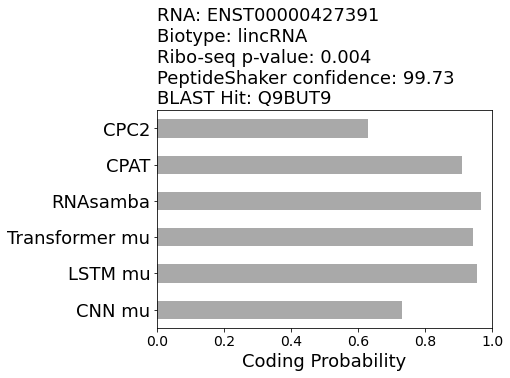

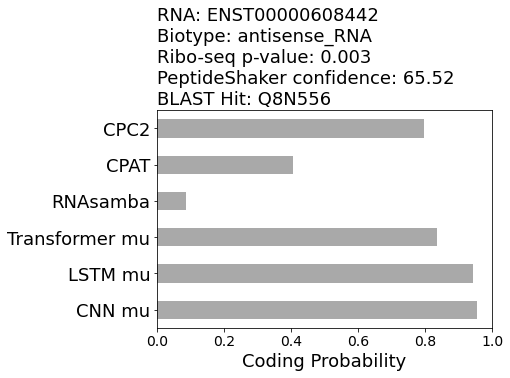

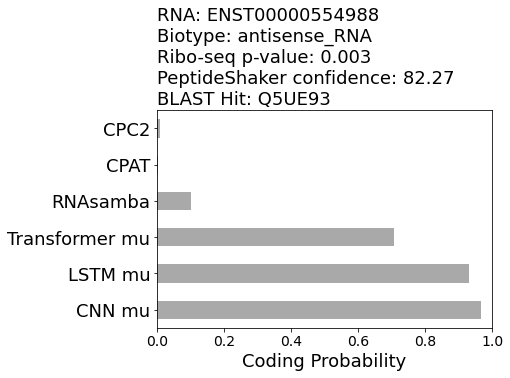

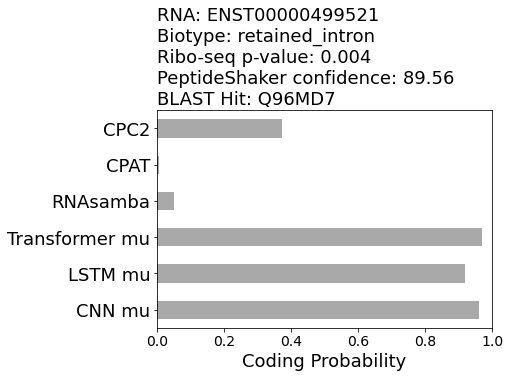

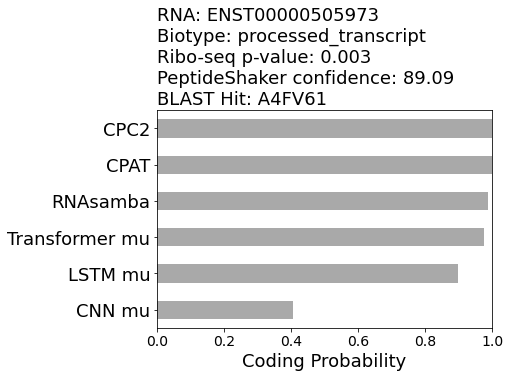

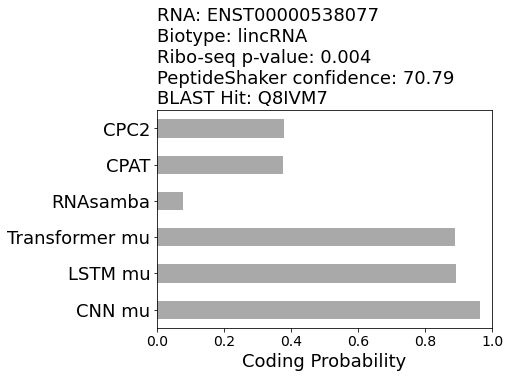

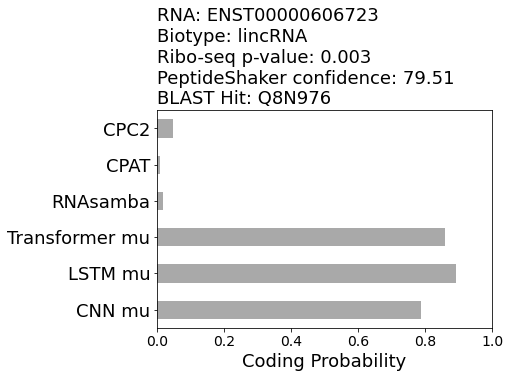

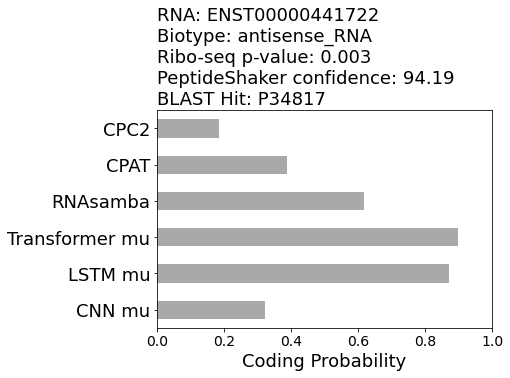

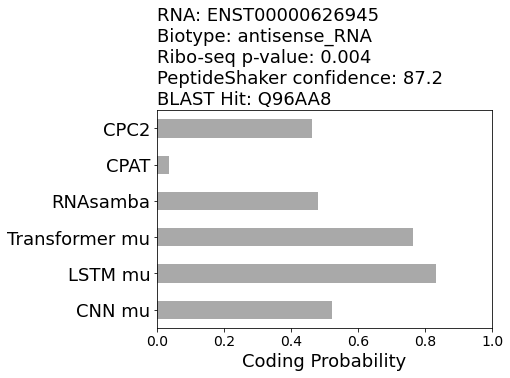

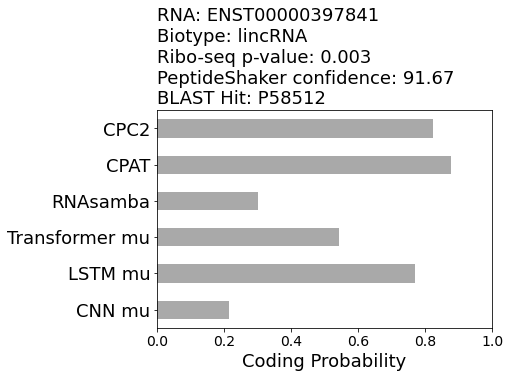

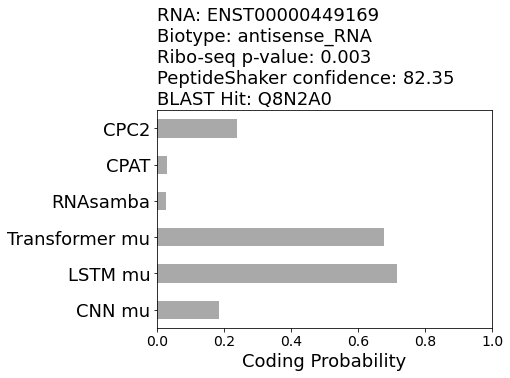

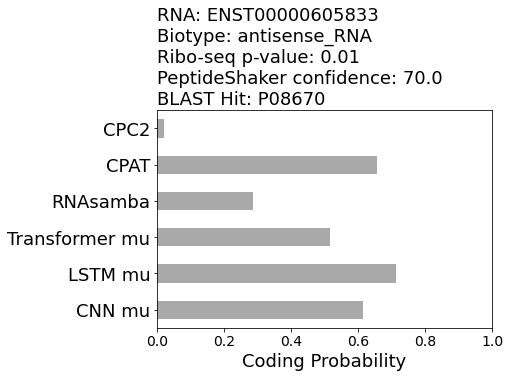

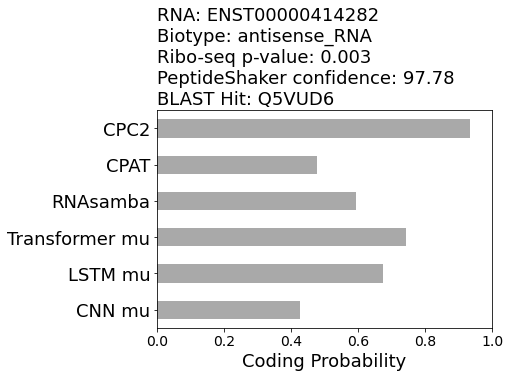

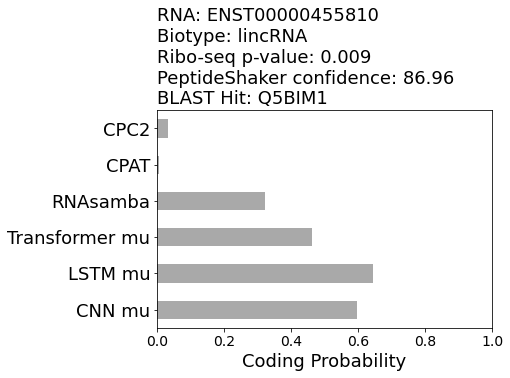

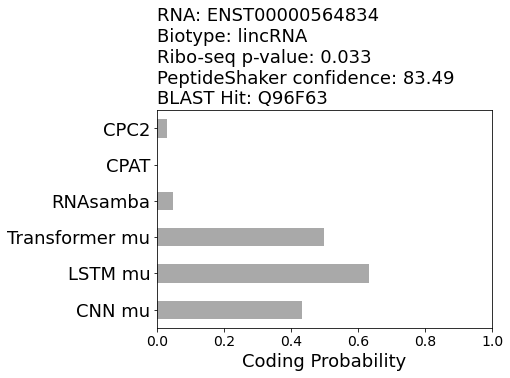

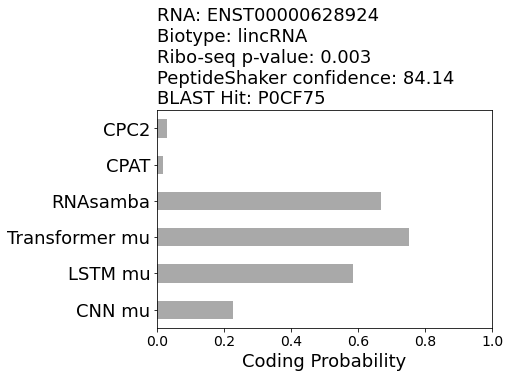

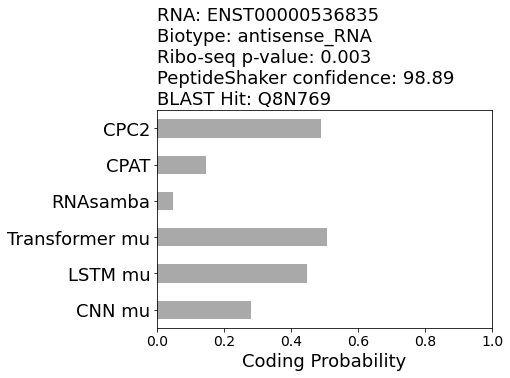

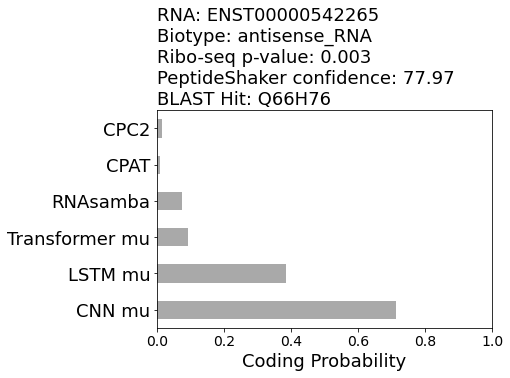

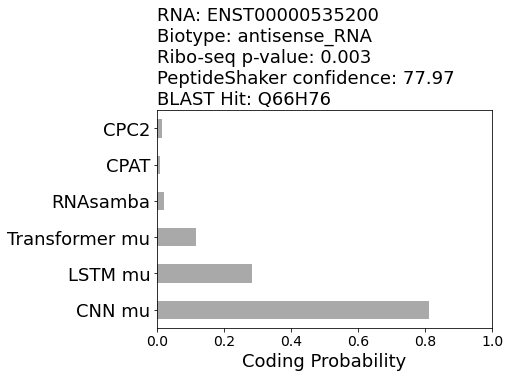

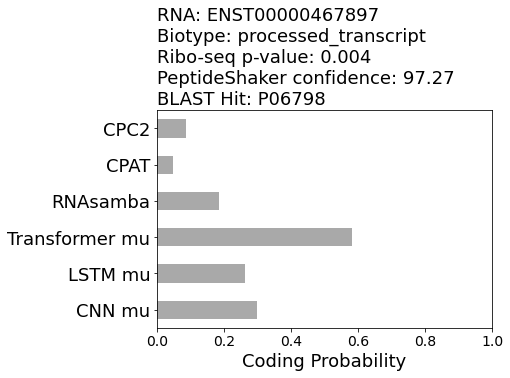

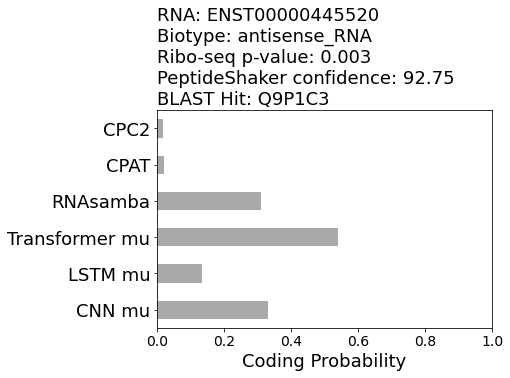

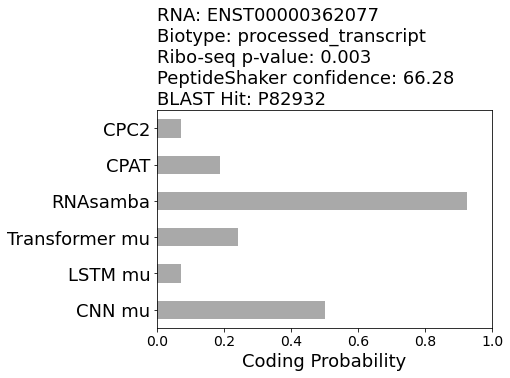

In [151]:
for i in (df.index):
    this_id = df.loc[i, 'ID']
    df.loc[i, ['CNN mu', 'LSTM mu', 'Transformer mu',
                'RNAsamba', 'CPAT', 'CPC2']].plot.barh(color='darkgrey')
    plt.xlabel('Coding Probability', fontsize=18)
    plt.yticks(fontsize=18)
    plt.xticks(fontsize=14)
    plt.xlim(0,1)
    plt.title(f"RNA: {df.loc[i, 'ID']}\nBiotype: {df.loc[i, 'Biotype']}\nRibo-seq p-value: {round(df.loc[i, 'Ribo-seq p-value'], 3)}\nPeptideShaker confidence: {round(df.loc[i, 'PeptideShaker confidence'], 2)}\nBLAST Hit: {df.loc[i, 'BLAST hit']}", 
              fontsize=18, loc='left')
    plt.savefig(f'figures/candidates/{this_id}.pdf', bbox_inches='tight', dpi=50)
    plt.show()
    